In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.style.use('/Users/mayafishbach/Desktop/gw-pop-numpyro/src/gw_pop_numpyro/maya.mplstyle')

import numpy as np

import jax.numpy as jnp

import h5py

import delay_time_helper

import gw_pop_numpyro

from gw_pop_numpyro import plot_helper, config

In [2]:
import seaborn as sns
sns.set_palette('colorblind')

In [3]:
tmax = config.cosmo_dict["lookback_time"](config.zmax)

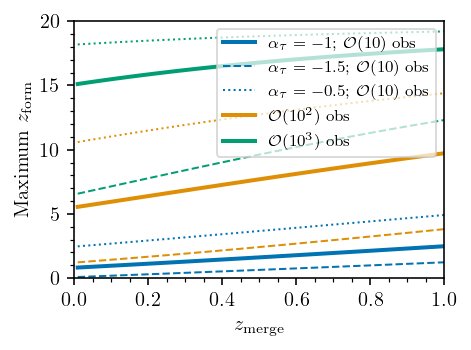

In [35]:
def calculate_z_f_quantile(z_m, q, tmin, alpha):
    
    t_m = config.cosmo_dict["lookback_time"](z_m)
    
    td_q = delay_time_helper.inverse_cdf_powerlaw(q, tmin = tmin, alpha = alpha, tmax = tmax - t_m)
        
    t_f = t_m + td_q
    
    z_f = config.cosmo_dict["z_at_lookback_time"](t_f)
    
    return z_f

zs_m = jnp.linspace(0.01, 1, 100)

qs = [0.9, 0.99, 0.999]

label_q = [r'$\mathcal{O}(10)$ obs', r'$\mathcal{O}(10^2)$ obs', r'$\mathcal{O}(10^3)$ obs']

alphas = [-1, -1.5,  -0.5]

label_al = [r'$\alpha_\tau = -1$', r'$\alpha_\tau = -1.5$', r'$\alpha_\tau = -0.5$']

tmin = 20

lss = ['-', '--', ':']

linewidths = [2.0, 1.0, 1.0]

for i, q in enumerate(qs):
    
    for j, al in enumerate(alphas):
        
        zs_f = calculate_z_f_quantile(zs_m, q, tmin, al)
        
                    
        label = None
        
        if i == 0:
            
                
                label = label_al[j] + "; " + label_q[i] 
            
            
        elif j == 0:
            
            label = label_q[i]
            
            
        plt.plot(zs_m, zs_f, ls = lss[j], linewidth = linewidths[j], color = sns.color_palette()[i], label = label)
            

plt.xlim(0, 1)
plt.ylim(0, 20)
plt.legend(loc = 'upper right', fancybox = True, frameon = True, framealpha = 0.7)
plt.xlabel(r'$z_\mathrm{merge}$')
plt.ylabel('Maximum $z_\mathrm{form}$')

plt.tight_layout()

plt.savefig("figures/zform-quantiles-v-zmerge.pdf")

plt.savefig("figures/zform-quantiles-v-zmerge.png", dpi = 300)

In [30]:
obs_samps_allparams = dict()

with h5py.File('/Users/mayafishbach/Desktop/gw-pop-numpyro/notebooks/reweighted_PE_GWTC3-defaultpop.h5', 'r') as inp:
    for key in inp.keys():
        obs_samps_allparams[key] = jnp.array(inp[key])

In [31]:
delay_time_helper.add_formation_tL(obs_samps_allparams, tmin = 20)

In [32]:
obs_samps_allparams["formation_redshift"] = config.cosmo_dict["z_at_lookback_time"](obs_samps_allparams["formation_lookback_time"])

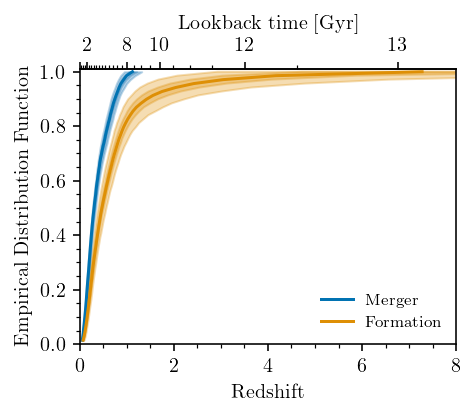

In [86]:
fig, ax = plt.subplots()
lines_zm = plot_helper.plot_cdf_bands(ax, obs_samps_allparams["redshift"], plot_kwargs = dict(label = 'Merger'), ret_lines = True)
lines_zf_tmin20alpha1 = plot_helper.plot_cdf_bands(ax, obs_samps_allparams["formation_redshift"], plot_kwargs = dict(label = 'Formation'), color = sns.color_palette()[1], ret_lines = True)

ax.set_ylim(0,1.01)
ax.set_xlim(0, 8)

ax.set_xlabel("Redshift")
ax.set_ylabel("Empirical Distribution Function")

plt.legend(loc = 'lower right')

#timeax = ax.secondary_xaxis('top', functions=(lambda z: config.cosmo_dict["lookback_time"](z)/1e3, lambda t: config.cosmo_dict["z_at_lookback_time"](t/1e3)))

timeax = ax.secondary_xaxis('top', functions=(config.cosmo_dict["lookback_time"], config.cosmo_dict["z_at_lookback_time"]))
timeax.set_xticks(ticks = [0, 2000, 8000, 10000, 12000, 13000, 13250], labels = ['', '2', '8', '10', '12', '13', '13.25'])


timeax.set_xlabel('Lookback time [Gyr]')

plt.savefig("figures/EDF_zmerge_zform_GWTC3.pdf", bbox_inches = 'tight')
plt.savefig("figures/EDF_zmerge_zform_GWTC3.png", dpi = 300, bbox_inches = 'tight')

In [36]:
formation_redshift_tmin20alpha15 = delay_time_helper.calculate_formation_redshift(obs_samps_allparams, tmin = 20, alpha = -1.5)

lines_zf_tmin20alpha15 = plot_helper.plot_cdf_bands(ax, formation_redshift_tmin20alpha15, plot_kwargs = dict(label = 'Formation'), color = sns.color_palette()[2], ret_lines = True)

formation_redshift_tmin20alpha05 = delay_time_helper.calculate_formation_redshift(obs_samps_allparams, tmin = 20, alpha = -0.5)

lines_zf_tmin20alpha05 = plot_helper.plot_cdf_bands(ax, formation_redshift_tmin20alpha05, plot_kwargs = dict(label = 'Formation'), color = sns.color_palette()[3], ret_lines = True)



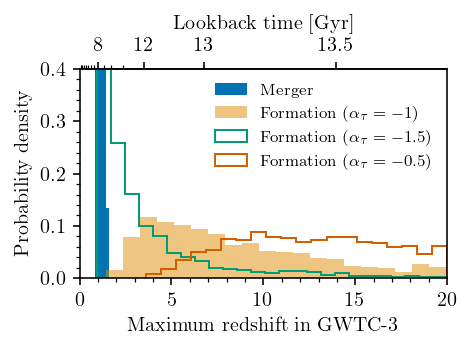

In [88]:
fig, ax = plt.subplots()

ax.hist(lines_zm[:,-1], bins = 5, density = True, label = 'Merger')
ax.hist(lines_zf_tmin20alpha1[:,-1], bins = 20, alpha = 0.5, density = True, label = r'Formation ($\alpha_\tau = -1$)')
ax.hist(lines_zf_tmin20alpha15[:,-1], bins = 25, alpha = 1, density = True, histtype = 'step', label = r'Formation ($\alpha_\tau = -1.5$)')
ax.hist(lines_zf_tmin20alpha05[:,-1], bins = 20, alpha = 1, density = True, histtype = 'step', label = r'Formation ($\alpha_\tau = -0.5$)')

ax.set_ylim(0, 0.4)
ax.set_xlim(0, 20)

timeax = ax.secondary_xaxis('top', functions=(config.cosmo_dict["lookback_time"], config.cosmo_dict["z_at_lookback_time"]))
timeax.set_xticks(ticks = [8000, 12000, 13000, 13500], labels = ['8', '12', '13', '13.5'])

timeax.set_xlabel('Lookback time [Gyr]')

ax.set_xlabel("Maximum redshift in GWTC-3")
ax.set_ylabel("Probability density")

plt.legend(loc = 'upper right')

plt.tight_layout()

plt.savefig("figures/max_zmerge_zform_GWTC3.pdf", bbox_inches = 'tight')
plt.savefig("figures/max_zmerge_zform_GWTC3.png", dpi = 300, bbox_inches = 'tight')

0.952


'4.0^{+3.0}_{-3.0}'

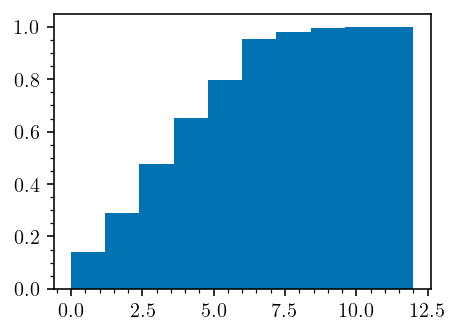

In [12]:
#how many events have formation redshifts above 2?
n_above_2 = np.zeros(1000)

for i in range(1000):
    x = (np.arange(69)[::-1])[lines_zf_tmin20alpha1[i,:] >= 2]
    if len(x) > 0:
        n_above_2[i] = x[0]
        
print(1 - sum(n_above_2 == 0)/len(n_above_2))
plt.hist(n_above_2, cumulative = True, density = True)
plot_helper.median_pm_symmetric(n_above_2)

In [13]:
print("we have observed at least one event with z > ", np.percentile(lines_zf_tmin20alpha1[:,-1], 10), "with 90\% credibility")



we have observed at least one event with z >  3.4631233692169188 with 90\% credibility


In [53]:
with h5py.File("formation_rate_vs_tL.h5", 'r') as inp:
    Rfs = np.array(inp["Rf_posterior"])
    Rfs_prior = np.array(inp["Rf_prior"])
    tL_forms = np.array(inp["tL_forms"])
    Mtot_avg = np.array(inp["Mtot_average"])

In [67]:
BBH_FR = (Rfs.T * Mtot_avg).T

In [60]:
from gw_pop_numpyro import distributions as dist

Ts = config.cosmo_dict["age_of_universe"] - tL_forms
SFR = 0.1 * dist.rate_age(Ts/1e3, 1.34, 0.43)

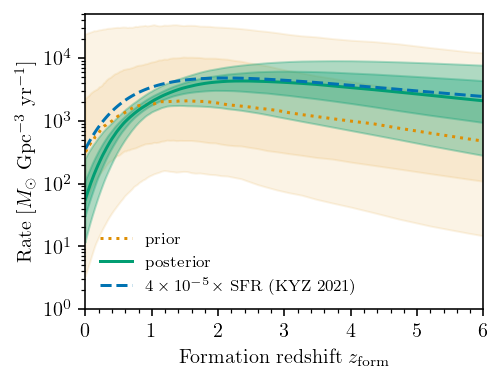

In [85]:

fig, ax = plt.subplots(constrained_layout=True)

xs = config.cosmo_dict["z_at_lookback_time"](tL_forms)

plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior * 30, plot_kwargs = dict(linewidth = 1.5, label = 'prior', ls = ':'), alpha = 0.1, color = sns.color_palette()[1])

plot_helper.plot_bands(ax, xs, 1e9 * BBH_FR, plot_kwargs = dict(linewidth = 1.5, label = 'posterior'), color = sns.color_palette()[2])


#ax.plot(xs, 10 * dist.redshift_peak(xs, a = 2.6, b = 6.2-2.6, zp = 2.2, zmax = 20), ls = '--', c = 'k')

ax.plot(xs, 1e9 * 4e-5 * SFR, ls = '--', color = sns.color_palette()[0], linewidth = 1.5, label = r'$4 \times 10^{-5}\times$ SFR (KYZ 2021)')


ax.set_yscale('log')

ax.set_xlim(0, 6)

ax.set_ylim(1, 5e4)

ax.set_xlabel('Formation redshift $z_\mathrm{form}$')

ax.set_ylabel('Rate [$M_\odot$ Gpc$^{-3}$ yr$^{-1}$]')

plt.legend(loc = 'lower left')


plt.savefig('figures/MassDensityRate_form_v_z_default_tau.pdf', bbox_inches = 'tight')

plt.savefig('figures/MassDensityRate_form_v_z_default_tau.png', dpi = 300, bbox_inches = 'tight')

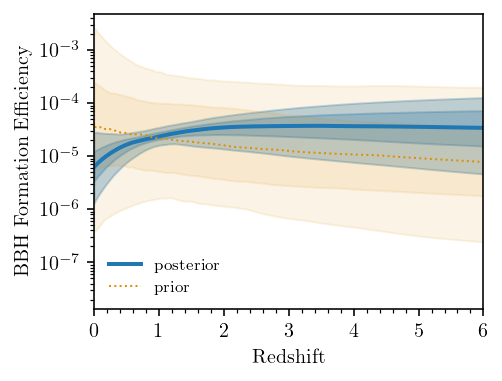

In [66]:


efficiency = BBH_FR / SFR

efficiency_prior = (Rfs_prior * 30)/ SFR


fig, ax = plt.subplots(constrained_layout=True)

plot_helper.plot_bands(ax, xs, efficiency, plot_kwargs = dict(linewidth = 2.0, label = 'posterior'))

plot_helper.plot_bands(ax, xs, efficiency_prior, plot_kwargs = dict(linewidth = 1.0, ls = ':', label = 'prior'), alpha = 0.1, color = sns.color_palette()[1])

plt.legend(loc = 'lower left')

ax.set_yscale('log')

ax.set_xlim(0,6)

ax.set_xlabel('Redshift')

ax.set_ylabel('BBH Formation Efficiency')

plt.savefig('figures/formation_efficiency_v_redshift_default_tau.pdf', bbox_inches = 'tight')
plt.savefig('figures/formation_efficiency_v_redshift_default_tau.png', bbox_inches = 'tight', dpi = 300)